In [1]:
import os
import shutil
from pathlib import Path
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

2025-06-27 07:47:37.645393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-27 07:47:37.667473: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 07:47:37.801858: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 07:47:37.901194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751021257.983024   97934 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751021258.01

In [2]:
origem = Path('animais')
treino = Path('animais/treino')
validacao = Path('animais/validacao')
teste = Path('animais/teste')
classes = ['WhalesDataset', 'ButterflyDataset', 'DogDataset']

In [4]:
# --- Separação das imagens em treino e validação ---
# --- Separação das imagens em treino, validação e teste em uma nova pasta ---
base_destino = Path('dataset_organizado')
treino = base_destino / 'treino'
validacao = base_destino / 'validacao'
teste = base_destino / 'teste'

for classe in classes:
    arquivos = sorted(os.listdir(origem / classe))
    n = len(arquivos)
    n_treino = int(0.7 * n)
    n_valid = int(0.15 * n)
    n_teste = n - n_treino - n_valid

    for split, start, end in [
        (treino, 0, n_treino),
        (validacao, n_treino, n_treino + n_valid),
        (teste, n_treino + n_valid, n)
    ]:
        (split / classe).mkdir(parents=True, exist_ok=True)
        for arquivo in arquivos[start:end]:
            shutil.copy(origem / classe / arquivo, split / classe / arquivo)

In [5]:
# --- Data Augmentation apenas no treino, cópia simples para validação e teste ---
base_aumentado = Path('dataset_aumentado')
aug_treino = base_aumentado / 'treino'
aug_validacao = base_aumentado / 'validacao'
aug_teste = base_aumentado / 'teste'

datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
img_size = (150, 150)
aug_treino.mkdir(parents=True, exist_ok=True)
aug_validacao.mkdir(parents=True, exist_ok=True)
aug_teste.mkdir(parents=True, exist_ok=True)

# Augmentation no treino
for classe in classes:
    input_path = treino / classe
    output_path = aug_treino / classe
    output_path.mkdir(parents=True, exist_ok=True)
    for img_file in os.listdir(input_path):
        img_path = input_path / img_file
        img = load_img(img_path, target_size=img_size)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_path, save_prefix=classe, save_format='jpeg'):
            i += 1
            if i >= 5:  # 10 aumentadas por imagem
                break

# Cópia simples para validação e teste
for split, origem_split, destino_split in [
    ('validacao', validacao, aug_validacao),
    ('teste', teste, aug_teste)
]:
    for classe in classes:
        input_path = origem_split / classe
        output_path = destino_split / classe
        output_path.mkdir(parents=True, exist_ok=True)
        for img_file in os.listdir(input_path):
            shutil.copy(input_path / img_file, output_path / img_file)

## Random Forest

In [6]:
def carregar_dados(pasta, classes, img_size):
    X, y = [], []
    for label, classe in enumerate(classes):
        for arquivo in os.listdir(pasta / classe):
            caminho_img = pasta / classe / arquivo
            try:
                img = load_img(caminho_img, target_size=img_size)
                img_array = img_to_array(img).flatten() / 255.0
                X.append(img_array)
                y.append(label)
            except:
                pass
    return np.array(X), np.array(y)

X_train, y_train = carregar_dados(aug_treino, classes, img_size)
X_val, y_val = carregar_dados(validacao, classes, img_size)
X_test, y_test = carregar_dados(teste, classes, img_size)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import numpy as np
import joblib 

n_runs = 15
accs_rf = []
f1s_rf = []
recalls_rf = []
precisions_rf = []
best_acc_rf = 0
best_model_rf = None

for i in range(n_runs):
    clf = RandomForestClassifier(n_estimators=100, random_state=i)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accs_rf.append(acc)
    f1s_rf.append(f1_score(y_test, y_pred, average='weighted'))
    recalls_rf.append(recall_score(y_test, y_pred, average='weighted'))
    precisions_rf.append(precision_score(y_test, y_pred, average='weighted'))
    if acc > best_acc_rf:
        best_acc_rf = acc
        best_model_rf = clf

joblib.dump(best_model_rf, "random_forest_melhor_modelo.joblib")

print("Acurácia média:", np.mean(accs_rf))
print("F1-score médio:", np.mean(f1s_rf))
print("Recall médio:", np.mean(recalls_rf))
print("Precision média:", np.mean(precisions_rf))
print("Melhor acurácia:", best_acc_rf)
print("Modelo salvo como random_forest_melhor_modelo.joblib")

Acurácia média: 0.7640826873385014
F1-score médio: 0.7641968926929757
Recall médio: 0.7640826873385014
Precision média: 0.7765425617393809
Melhor acurácia: 0.7829457364341085
Modelo salvo como random_forest_melhor_modelo.joblib


Random Forest (Melhor Modelo):
                  precision    recall  f1-score   support

   WhalesDataset       0.99      0.94      0.96        86
ButterflyDataset       0.77      0.58      0.66        86
      DogDataset       0.64      0.83      0.72        86

        accuracy                           0.78       258
       macro avg       0.80      0.78      0.78       258
    weighted avg       0.80      0.78      0.78       258

Acurácia: 0.7829457364341085
F1-score: 0.7824498508853234
Recall: 0.7829457364341085
Precision: 0.7988917623063966


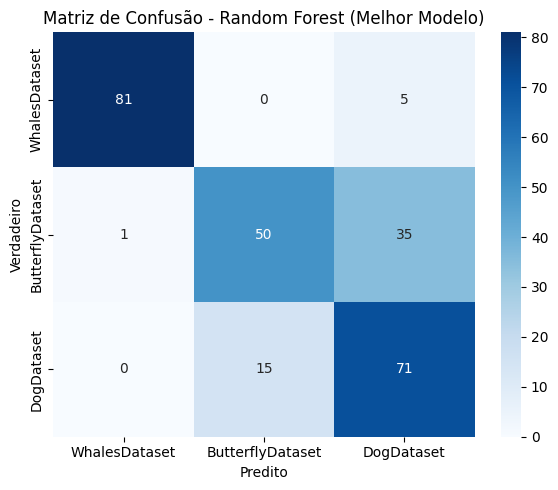

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_pred_best = best_model_rf.predict(X_test)

print("Random Forest (Melhor Modelo):")
print(classification_report(y_test, y_pred_best, target_names=classes))
print("Acurácia:", accuracy_score(y_test, y_pred_best))
print("F1-score:", f1_score(y_test, y_pred_best, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_best, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_best, average='weighted'))

cm_rf = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Random Forest (Melhor Modelo)')
plt.tight_layout()
plt.show()

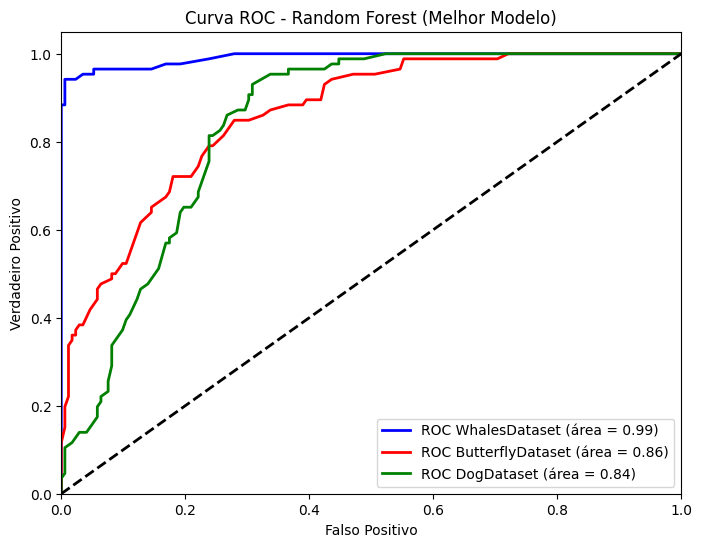

In [9]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# --- Random Forest ROC (usando o melhor modelo) ---
y_test_bin = label_binarize(y_test, classes=range(len(classes)))
if hasattr(best_model_rf, "predict_proba"):
    y_score_rf = best_model_rf.predict_proba(X_test)
else:
    y_score_rf = best_model_rf.decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC {classes[i]} (área = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC - Random Forest (Melhor Modelo)')
plt.legend(loc="lower right")
plt.show()

## MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import numpy as np

n_runs = 15
accs = []
f1s = []
recalls = []
precisions = []
best_acc = 0
best_model = None

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 32

train_gen = train_datagen.flow_from_directory(
    str(aug_treino),
    target_size=img_size,
    classes=classes,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)
val_gen = val_datagen.flow_from_directory(
    str(aug_validacao), 
    target_size=img_size,
    classes=classes,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)
test_gen = test_datagen.flow_from_directory(
    str(aug_teste), 
    target_size=img_size,
    classes=classes,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

for i in range(n_runs):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    output = Dense(len(classes), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_gen,
        epochs=10,
        validation_data=val_gen,
        verbose=0 
    )
    y_pred_mobilenet = model.predict(test_gen)
    y_pred_mobilenet_labels = np.argmax(y_pred_mobilenet, axis=1)
    y_true_mobilenet = test_gen.classes
    acc = accuracy_score(y_true_mobilenet, y_pred_mobilenet_labels)
    accs.append(acc)
    f1s.append(f1_score(y_true_mobilenet, y_pred_mobilenet_labels, average='weighted'))
    recalls.append(recall_score(y_true_mobilenet, y_pred_mobilenet_labels, average='weighted'))
    precisions.append(precision_score(y_true_mobilenet, y_pred_mobilenet_labels, average='weighted'))
    # Salva o melhor modelo
    if acc > best_acc:
        best_acc = acc
        best_model = model

print("Acurácia média:", np.mean(accs))
print("F1-score médio:", np.mean(f1s))
print("Recall médio:", np.mean(recalls))
print("Precision média:", np.mean(precisions))
print("Melhor acurácia:", best_acc)

Found 5344 images belonging to 3 classes.
Found 252 images belonging to 3 classes.
Found 258 images belonging to 3 classes.


/tmp/ipykernel_97934/3146641789.py:51: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
2025-06-27 12:14:16.286994: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/jullia/miniconda3/envs/avanti/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step


/tmp/ipykernel_97934/3146641789.py:51: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step


/tmp/ipykernel_97934/3146641789.py:51: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step


/tmp/ipykernel_97934/3146641789.py:51: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 373ms/step


/tmp/ipykernel_97934/3146641789.py:51: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 366ms/step


/tmp/ipykernel_97934/3146641789.py:51: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 373ms/step


/tmp/ipykernel_97934/3146641789.py:51: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 377ms/step


/tmp/ipykernel_97934/3146641789.py:51: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 405ms/step


/tmp/ipykernel_97934/3146641789.py:51: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step


/tmp/ipykernel_97934/3146641789.py:51: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step


/tmp/ipykernel_97934/3146641789.py:51: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 352ms/step


/tmp/ipykernel_97934/3146641789.py:51: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 386ms/step


/tmp/ipykernel_97934/3146641789.py:51: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 435ms/step


/tmp/ipykernel_97934/3146641789.py:51: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 355ms/step


/tmp/ipykernel_97934/3146641789.py:51: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step
Acurácia média: 0.9855297157622739
F1-score médio: 0.9855161099539004
Recall médio: 0.9855297157622739
Precision média: 0.9856263569566676
Melhor acurácia: 1.0


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step
MobileNetV2 (Melhor Modelo):
                  precision    recall  f1-score   support

   WhalesDataset       1.00      1.00      1.00        86
ButterflyDataset       1.00      1.00      1.00        86
      DogDataset       1.00      1.00      1.00        86

        accuracy                           1.00       258
       macro avg       1.00      1.00      1.00       258
    weighted avg       1.00      1.00      1.00       258

Acurácia: 1.0
F1-score: 1.0
Recall: 1.0
Precision: 1.0


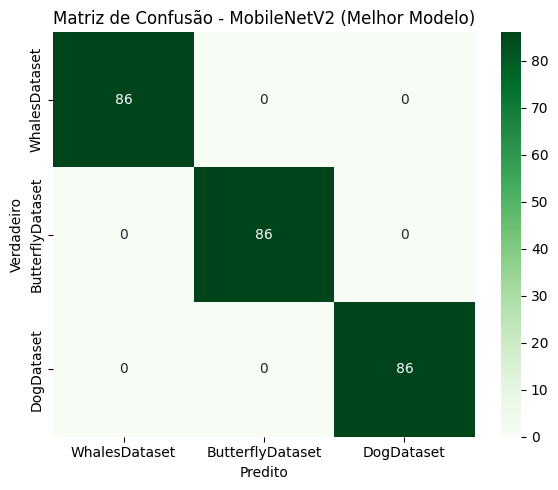

In [ ]:
# --- MobileNetV2 (Melhor Modelo) ---
y_pred_best_mobilenet = best_model.predict(test_gen)
y_pred_best_mobilenet_labels = np.argmax(y_pred_best_mobilenet, axis=1)
y_true_mobilenet = test_gen.classes

print("MobileNetV2 (Melhor Modelo):")
print(classification_report(y_true_mobilenet, y_pred_best_mobilenet_labels, target_names=classes))
print("Acurácia:", accuracy_score(y_true_mobilenet, y_pred_best_mobilenet_labels))
print("F1-score:", f1_score(y_true_mobilenet, y_pred_best_mobilenet_labels, average='weighted'))
print("Recall:", recall_score(y_true_mobilenet, y_pred_best_mobilenet_labels, average='weighted'))
print("Precision:", precision_score(y_true_mobilenet, y_pred_best_mobilenet_labels, average='weighted'))

cm_mobilenet = confusion_matrix(y_true_mobilenet, y_pred_best_mobilenet_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_mobilenet, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap="Greens")
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - MobileNetV2 (Melhor Modelo)')
plt.tight_layout()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step


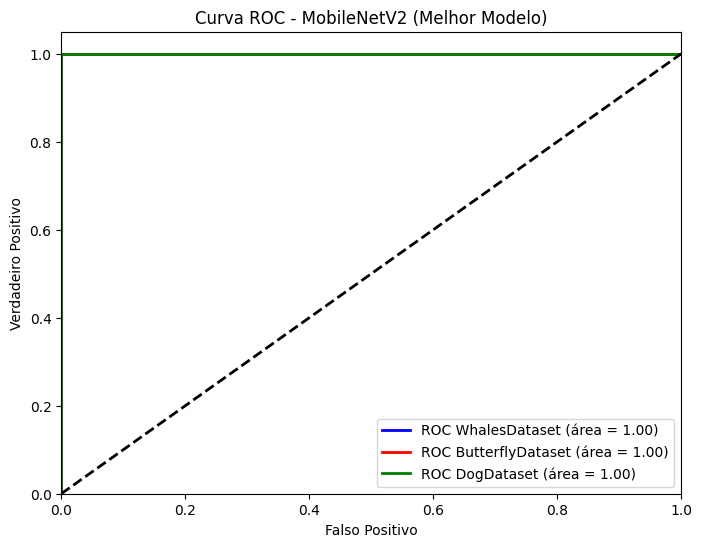

In [ ]:
from tensorflow.keras.utils import to_categorical

y_pred_best_mobilenet = best_model.predict(test_gen)
y_pred_best_mobilenet_labels = np.argmax(y_pred_best_mobilenet, axis=1)
y_true_mobilenet = test_gen.classes

y_true_mobilenet_bin = to_categorical(y_true_mobilenet, num_classes=len(classes))
y_score_mobilenet = y_pred_best_mobilenet  

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_mobilenet_bin[:, i], y_score_mobilenet[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC {classes[i]} (área = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC - MobileNetV2 (Melhor Modelo)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pandas as pd

y_pred_best = best_model_rf.predict(X_test)
y_pred_best_mobilenet = best_model.predict(test_gen)
y_pred_best_mobilenet_labels = np.argmax(y_pred_best_mobilenet, axis=1)
y_true_mobilenet = test_gen.classes

dados = {
    "Modelo": ["Random Forest", "MobileNetV2"],
    "Acurácia": [accuracy_score(y_test, y_pred_best), accuracy_score(y_true_mobilenet, y_pred_best_mobilenet_labels)],
    "F1-score": [f1_score(y_test, y_pred_best, average='weighted'), f1_score(y_true_mobilenet, y_pred_best_mobilenet_labels, average='weighted')],
    "Recall": [recall_score(y_test, y_pred_best, average='weighted'), recall_score(y_true_mobilenet, y_pred_best_mobilenet_labels, average='weighted')],
    "Precision": [precision_score(y_test, y_pred_best, average='weighted'), precision_score(y_true_mobilenet, y_pred_best_mobilenet_labels, average='weighted')]
}
df = pd.DataFrame(dados)
display(df)

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step


,Modelo,Acurácia,F1-score,Recall,Precision
0,Random Forest,0.782946,0.78245,0.782946,0.798892
1,MobileNetV2,1.000000,1.00000,1.000000,1.000000


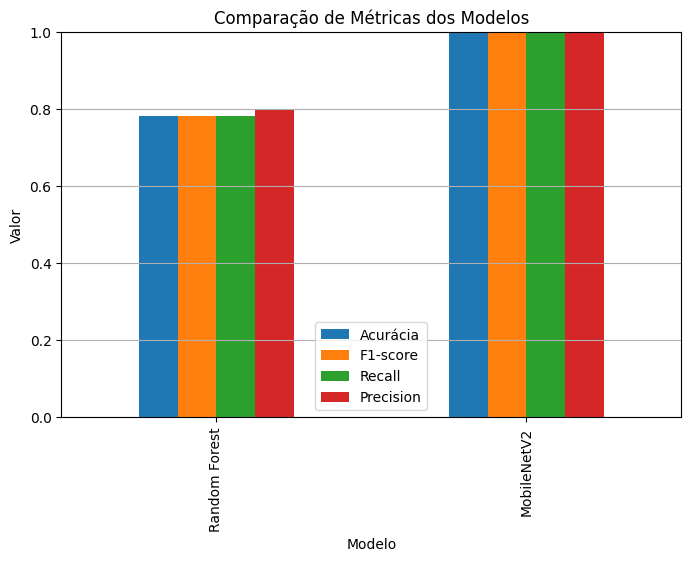

In [ ]:
df.set_index("Modelo").plot(kind="bar", figsize=(8,5))
plt.title("Comparação de Métricas dos Modelos")
plt.ylabel("Valor")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()